# 以移动平均线为预测指标的LSTM模型

In [1]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import os
from sklearn.metrics import mean_squared_error
import datetime
import tensorflow as tf
from tensorflow.contrib import learn
from tensorflow.python.ops import rnn, rnn_cell
import matplotlib.pyplot as plt
import cPickle
import gzip
# import seaborn as sns
from sklearn import preprocessing
import random
%matplotlib inline

In [4]:
path = '/home/chocolate/LSTM-source/Main_product/'
data = pd.read_csv(path + 'IF_main_short.csv')
# data

In [5]:
ser_1 = data['Dis_EMA5_26'][1:]
ser_1.index = range(len(ser_1))
data['Dis_EMA5_26_PRED'] = ser_1


In [6]:
data = data.drop(data.columns[6:8],axis = 1)
data

,Unnamed: 0,Time,Latestprice,MaxPrice,MinPrice,Stockup,Volume,First.Latestprice,Last.Buy1price,Last.Buy1quantity,...,Vol_MA_26,Dis_Vol_MA5_26,Vol_EMA_5,Vol_EMA_12,Vol_EMA_26,Dis_Vol_EMA5_26,DIFF_12_26,DEA_12_26,MACD,Dis_EMA5_26_PRED
0,0,2016/01/04 09:40:00,3640.4,3646.0,3640.2,-63,106,3644.8,3640.2,2,...,NaN,NaN,106.000000,106.000000,106.000000,0.000000,0.000000,0.000000,0.000000,-1.179231
1,1,2016/01/04 09:41:00,3625.8,3641.4,3624.4,-79,210,3640.4,3625.0,4,...,NaN,NaN,168.400000,162.333333,160.000000,8.400000,-0.327564,-0.181980,-0.291168,-2.224363
2,2,2016/01/04 09:42:00,3618.8,3626.8,3612.6,-110,278,3625.4,3619.2,1,...,NaN,NaN,220.315789,207.478060,202.396254,17.919535,-0.634451,-0.367419,-0.534064,-2.764932
3,3,2016/01/04 09:43:00,3617.0,3620.2,3616.0,-81,150,3618.8,3616.8,5,...,NaN,NaN,191.107692,189.334483,187.748551,3.359141,-0.823469,-0.521908,-0.603123,-2.732129
4,4,2016/01/04 09:44:00,3618.0,3618.8,3613.0,-66,132,3616.8,3618.0,2,...,NaN,NaN,168.417062,173.756909,174.820232,-6.403171,-0.869050,-0.625175,-0.487751,-2.096789
5,5,2016/01/04 09:44:00,3621.0,3621.6,3618.0,-47,103,3618.2,3621.0,1,...,NaN,NaN,144.512782,156.559257,160.435213,-15.922431,-0.751834,-0.659506,-0.184655,-2.862444
6,6,2016/01/04 09:46:00,3614.2,3621.4,3614.2,-46,111,3621.0,3612.8,2,...,NaN,NaN,132.647402,146.392868,151.643416,-18.996015,-0.971763,-0.738530,-0.466465,-5.591120
7,7,2016/01/04 09:46:00,3601.2,3615.6,3600.0,-98,344,3614.2,3601.0,1,...,NaN,NaN,205.958763,187.630431,182.636828,23.321935,-1.721885,-0.974849,-1.494072,-6.744570
8,8,2016/01/04 09:47:00,3602.2,3608.6,3600.4,-68,181,3601.2,3602.2,2,...,NaN,NaN,197.416984,186.318696,182.394214,15.022770,-2.165518,-1.249899,-1.831237,-6.683214
9,9,2016/01/04 09:49:00,3604.6,3608.4,3599.0,-70,184,3602.0,3603.4,1,...,NaN,NaN,192.865730,185.879304,182.615797,10.249933,-2.325090,-1.490804,-1.668572,-6.865410


In [7]:
new_path = '/home/chocolate/LSTM-source/Main_product_added_features/'
data.to_csv(new_path+'IF_main_short_addfeatures.csv')

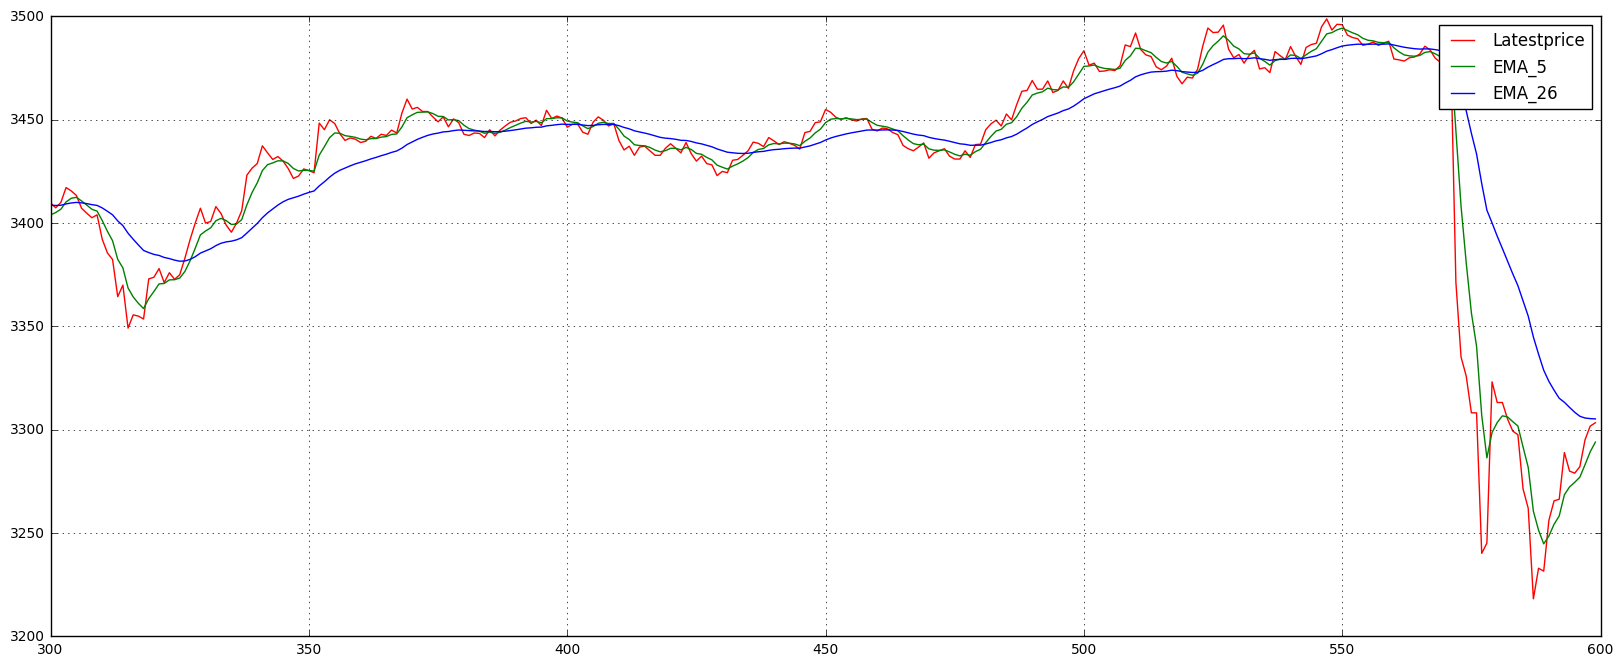

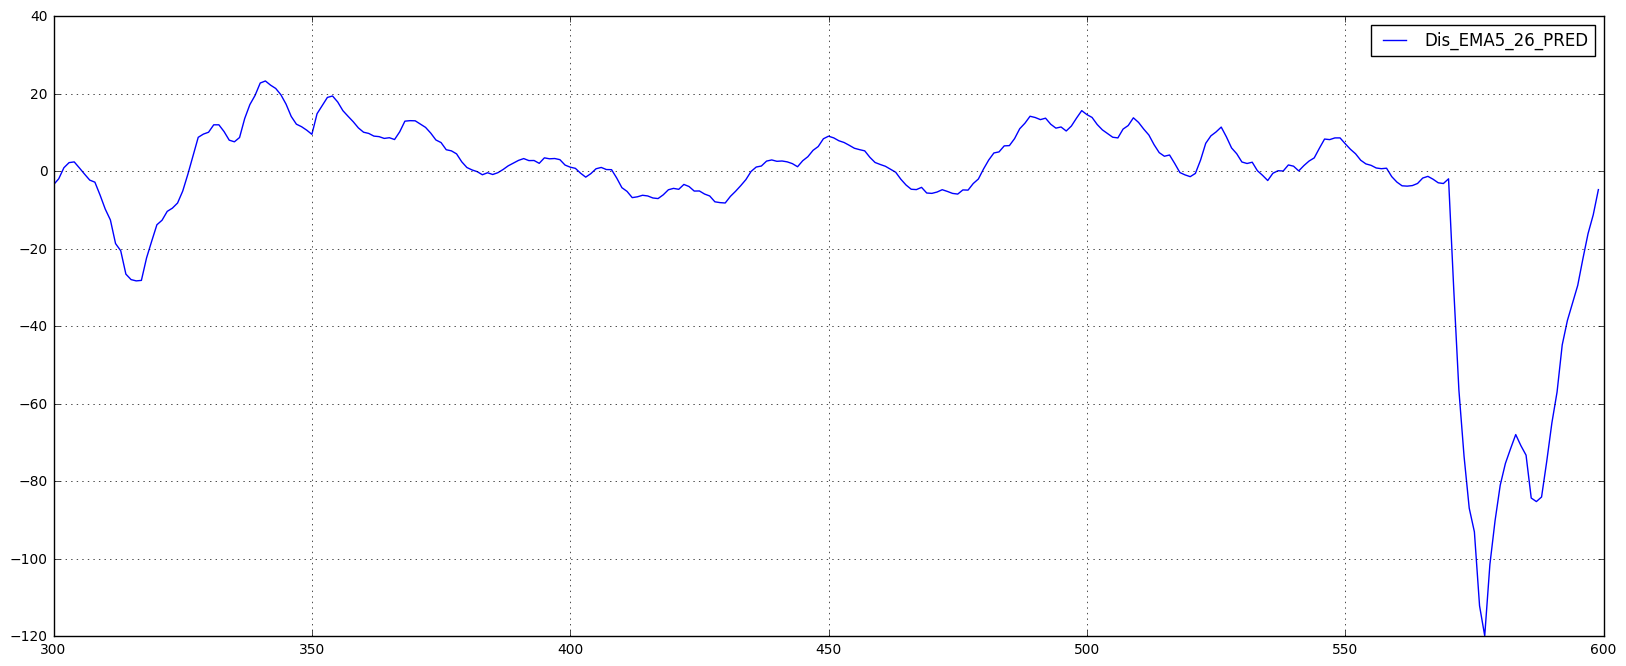

In [65]:
plt.figure(figsize=(20,8)) 
# plt.title(u"IC1611_EMA")
plt.plot(data['Latestprice'][300:600],'r-',label = 'Latestprice')
plt.plot(data['EMA_5'][300:600],'g-',label = 'EMA_5')
plt.plot(data['EMA_26'][300:600],"b-",label = 'EMA_26')
# plt.plot(newdata1['EMA_10'][100:300],"b-",label = 'EMA_10')
# plt.plot(newdata1['EMA_20'][100:300],"black",label = 'EMA_20')
plt.legend()
plt.grid()

plt.figure(figsize=(20,8)) 
# plt.title(u"IC1611_EMA")
# plt.plot(data['Latestprice'][200:500], "g-", label="Latestprice",linewidth=1)
# plt.plot(data['EMA_5'][200:500],"r-",label = 'MA_5')
plt.plot(data['Dis_EMA5_26_PRED'][300:600],"b-",label = 'Dis_EMA5_26_PRED')
plt.legend()
plt.grid()
plt.show()

In [12]:
# 制作数据集
path = '/home/chocolate/LSTM-source/Main_product_added_features/'
seq_new_15 = []

data = pd.read_csv(path + 'IF_main_short_addfeatures.csv')
data_new = data.drop(data.columns[13:],axis = 1)
# data_new.fillna('ffill')
data_new = data_new.ix[:, 3:]
# 最后一分钟的预测特征为空值，会影响结果，予以删除
data_new = data_new[:-1]
data_new.index = range(len(data_new))
# data_new


### 策略中归一化需要用到数据集中的最大最小值，利用下面几段代码求最大最小值

In [13]:
# 仍有几个异常数据，清理掉
data_new['Last.Buy1price'][data_new['Last.Buy1price'] <= 2000] = None
data_new['Last.Buy1quantity'][data_new['Last.Buy1quantity'] >= 50] = None
data_new['Last.Sell1quantity'][data_new['Last.Sell1quantity'] >= 50] = None
data_new = data_new.dropna()
data_new.index = range(len(data_new))
data_new


,Latestprice,MaxPrice,MinPrice,Stockup,Volume,First.Latestprice,Last.Buy1price,Last.Buy1quantity,Last.Sell1price,Last.Sell1quantity
0,3640.4,3646.0,3640.2,-63,106,3644.8,3640.2,2.0,3641.4,1.0
1,3625.8,3641.4,3624.4,-79,210,3640.4,3625.0,4.0,3626.8,1.0
2,3618.8,3626.8,3612.6,-110,278,3625.4,3619.2,1.0,3620.0,11.0
3,3617.0,3620.2,3616.0,-81,150,3618.8,3616.8,5.0,3618.0,5.0
4,3618.0,3618.8,3613.0,-66,132,3616.8,3618.0,2.0,3618.2,2.0
5,3621.0,3621.6,3618.0,-47,103,3618.2,3621.0,1.0,3621.2,2.0
6,3614.2,3621.4,3614.2,-46,111,3621.0,3612.8,2.0,3613.8,1.0
7,3601.2,3615.6,3600.0,-98,344,3614.2,3601.0,1.0,3602.8,1.0
8,3602.2,3608.6,3600.4,-68,181,3601.2,3602.2,2.0,3603.0,2.0
9,3604.6,3608.4,3599.0,-70,184,3602.0,3603.4,1.0,3604.6,1.0


In [14]:
columns = list(data_new.columns)
for col in columns:
     print data_new[col].min(),data_new[col].max()

2755.8 3640.4
2762.2 3646.0
2732.4 3640.2
-256 211
1 1514
2755.6 3644.8
2755.4 3640.2
1.0 48.0
2759.0 3641.4
1.0 46.0


In [15]:
columns = list(data_new.columns)
for col in columns:
     data_new[col] = (data_new[col] - data_new[col].min())/(data_new[col].max() - data_new[col].min())
data_new

,Latestprice,MaxPrice,MinPrice,Stockup,Volume,First.Latestprice,Last.Buy1price,Last.Buy1quantity,Last.Sell1price,Last.Sell1quantity
0,1.000000,1.000000,1.000000,0.413276,0.069399,1.000000,1.000000,0.021277,1.000000,0.000000
1,0.983495,0.994795,0.982595,0.379015,0.138136,0.995052,0.982821,0.063830,0.983454,0.000000
2,0.975582,0.978276,0.969597,0.312634,0.183080,0.978183,0.976266,0.000000,0.975748,0.222222
3,0.973547,0.970808,0.973342,0.374732,0.098480,0.970760,0.973553,0.085106,0.973481,0.088889
4,0.974678,0.969224,0.970037,0.406852,0.086583,0.968511,0.974910,0.021277,0.973708,0.022222
5,0.978069,0.972392,0.975545,0.447537,0.067416,0.970085,0.978300,0.000000,0.977108,0.022222
6,0.970382,0.972166,0.971359,0.449679,0.072703,0.973234,0.969033,0.021277,0.968722,0.000000
7,0.955686,0.965603,0.955717,0.338330,0.226702,0.965587,0.955696,0.000000,0.956256,0.000000
8,0.956817,0.957683,0.956158,0.402570,0.118969,0.950967,0.957052,0.021277,0.956482,0.022222
9,0.959530,0.957456,0.954616,0.398287,0.120952,0.951867,0.958409,0.000000,0.958296,0.000000


In [16]:
#   数据归一化
data_array_per = np.array(data_new)
min_max_scaler = preprocessing.MinMaxScaler()
data_array_per = min_max_scaler.fit_transform(data_array_per)
#  组时间序列
for k in range(len(data_array_per)):
    if k < len(data_array_per) and k >= 15:
        seq_new_15.append(data_array_per[k - 15:k])
seq_new_15 = np.array(seq_new_15)
print seq_new_15.shape

(35729, 15, 10)


<font color='red'>利用均线距离进行分类：</font>分为5类（上涨 0，上涨趋势回调 1，平稳或小幅震荡 2，下跌 3，下跌趋势回调 4）<br>
上涨：未来5分钟均线距离大于0，并且逐步增加，在第5分钟结束时均线距离大于3。<br>
上涨趋势回调：未来5分钟内均线距离大于0，并且逐步减小，在第1分钟开始时均线距离是大于3的。<br>
下跌：未来5分钟均线距离小于0，并且逐步减小，在第5分钟结束时均线距离小于-3。<br>
下跌趋势回调：未来5分钟均线距离小于0，并且逐步增加，在第1分钟开始时均线距离是小于-3的。<br>
平稳或小幅震荡：其他情况。<br>

In [21]:
# 通过查看均线之间的距离变化来标注股价的走势
def label_judge_EMADistance(data,time_length):
    longup_count = 0
    shortdown_count = 0
    longdown_count = 0
    shortup_count = 0
    is_longlast5 = False
    is_shortlast5 = False
    is_longbegin1 = False
    is_shortbegin1 = False    
    for i in range(len(data))[1:]:
        if data['Dis_EMA5_26_PRED'].iloc[i] > 0 and data['Dis_EMA5_26_PRED'].iloc[i] > data['Dis_EMA5_26_PRED'].iloc[i-1]:
            longup_count += 1
        if data['Dis_EMA5_26_PRED'].iloc[i] < 0 and data['Dis_EMA5_26_PRED'].iloc[i] < data['Dis_EMA5_26_PRED'].iloc[i-1]:
            shortdown_count += 1
        if data['Dis_EMA5_26_PRED'].iloc[i] > 0 and data['Dis_EMA5_26_PRED'].iloc[i] < data['Dis_EMA5_26_PRED'].iloc[i-1]:
            longdown_count += 1
        if data['Dis_EMA5_26_PRED'].iloc[i] < 0 and data['Dis_EMA5_26_PRED'].iloc[i] > data['Dis_EMA5_26_PRED'].iloc[i-1]:
            shortup_count += 1 
        if i == 1:
            if data['Dis_EMA5_26_PRED'].iloc[i] >= 2:
                is_longbegin1 = True
            if data['Dis_EMA5_26_PRED'].iloc[i] <= -2:
                is_shortbegin1 = True
        if i == len(data)-1:
            if data['Dis_EMA5_26_PRED'].iloc[i] >= 2:
                is_longlast5 = True
            if data['Dis_EMA5_26_PRED'].iloc[i] <= -2:
                is_shortlast5 = True
    if longup_count == time_length-1 and is_longlast5 == True:
        return [1,0,0,0,0]                            #  未来五分钟上涨
    if longdown_count == time_length-1 and is_longbegin1 == True:
        return [0,1,0,0,0]                            #  未来五分钟上涨趋势回调
    if shortdown_count == time_length-1 and is_shortlast5 == True:
        return [0,0,0,1,0]                            #  未来五分钟下跌
    if shortup_count == time_length-1 and is_shortbegin1 == True:
        return [0,0,0,0,1]                            #  未来五分钟下跌趋势回调
    
    return [0,0,1,0,0]                                #  未来五分钟平稳

In [22]:
seq_label = []
for i in range(len(data))[15:-1]:
    seq_label.append(label_judge_EMADistance(data[i:i+5],5))

In [23]:
seq_label_array = np.array(seq_label)
seq_label_array.shape

(35742, 5)

In [24]:
print u'上   涨：',seq_label.count([1,0,0,0,0]),seq_label.count([1,0,0,0,0]) /35742.0
print u'上涨回调：',seq_label.count([0,1,0,0,0]),seq_label.count([0,1,0,0,0]) /35742.0
print u'平稳震荡：',seq_label.count([0,0,1,0,0]),seq_label.count([0,0,1,0,0]) /35742.0
print u'下   跌：',seq_label.count([0,0,0,1,0]),seq_label.count([0,0,0,1,0]) /35742.0
print u'下跌回调：',seq_label.count([0,0,0,0,1]),seq_label.count([0,0,0,0,1]) /35742.0

上   涨： 1860 0.052039617257
上涨回调： 2642 0.073918639136
平稳震荡： 26974 0.754686363382
下   跌： 1876 0.0524872698786
下跌回调： 2390 0.0668681103464


In [25]:
from random import shuffle
zip_seq = zip(seq_new_15,seq_label)
shuffle(zip_seq)
seq_new_15,seq_label = zip(*zip_seq)
seq_new_15 = np.array(seq_new_15) 
seq_label = np.array(seq_label)
print seq_new_15.shape, seq_label.shape

(35729, 15, 10) (35729, 5)


In [26]:
train_data = seq_new_15[:25000]
train_label = seq_label[:25000]

test_data = seq_new_15[25000:]
test_label = seq_label[25000:]
train_data.shape, test_label.shape

((25000, 15, 10), (10729, 5))

In [27]:
path_new = '/home/chocolate/LSTM-source/train_test_data/'
f1 = file(path_new + 'train_data_7.npy','wb')
np.save(f1,train_data)
f1.close()
f2 = file(path_new + 'test_data_7.npy','wb')
np.save(f2,test_data)
f2.close()
f3 = file(path_new + 'train_label_7.npy','wb')
np.save(f3,train_label)
f3.close()
f4 = file(path_new + 'test_label_7.npy','wb')
np.save(f4,test_label)
f4.close()

In [32]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import os
import datetime
import tensorflow as tf
from tensorflow.contrib import learn
from tensorflow.python.ops import rnn, rnn_cell
import matplotlib.pyplot as plt
import cPickle
import gzip
from sklearn import preprocessing
%matplotlib inline

In [33]:
path_new = '/home/chocolate/LSTM-source/train_test_data/'
# 读取训练集和测试集
f1 = file(path_new + 'train_data_7.npy','rb')
train_data = np.load(f1)
f2 = file(path_new + 'test_data_7.npy','rb')
test_data = np.load(f2)
f3 = file(path_new + 'train_label_7.npy','rb')
train_label = np.load(f3)
f4 = file(path_new + 'test_label_7.npy','rb')
test_label = np.load(f4)

In [34]:
import random

learning_rate = 0.001 # 学习速率
training_iters = 300000  # 训练总步长
batch_size = 5000 # 每小段步长
display_step = 5  # 每隔100小段显示输出

# 参数设置
n_input = 10 # 特征数量
n_steps = 15 # 时间序列长度
n_hidden = 500 # 隐藏层神经元个数
n_classes = 5 # 分类数量

tf.reset_default_graph()  # 重置流图
# 设置输入输出格式大小
xtr = tf.placeholder("float", [None, n_steps, n_input])
ytr = tf.placeholder("float", [None,n_classes])

# 定义权重和偏移量
weights = {
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# def pred():
    
def RNN(x, weights, biases):

    # 更改数据集的格式，使其满足RNN网络的输入需求
    # 现在输入格式: (batch_size, n_steps, n_input)
    # 需要的格式: 'n_steps' 个tensor，每个的格式为 (batch_size, n_input)

    # 变换batch_size 和 n_steps的位置
    x = tf.transpose(x, [1, 0, 2])
    # 重新调整格式 (n_steps*batch_size, n_input)
    x = tf.reshape(x, [-1, n_input])
    # 分割成一系列的 'n_steps' 个tensors，每个的格式为 (batch_size, n_input)
    x = tf.split(0, n_steps, x)

    # 定义LSTM神经网络结构
    lstm_cell = rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0)
    # 获取输出和状态
    outputs, states = rnn.rnn(lstm_cell, x, dtype=tf.float32)
    # 返回输出
    return tf.matmul(outputs[-1], weights['out']) + biases['out']
# 获取预测值
pred = RNN(xtr, weights, biases)
# train_label = tf.split(0, batch_size, train_label)
# 取下一小段的输入
def next_batch_tr(batch_size):
    step = random.randint(1, len(train_data)/batch_size)
    next_batch_data = train_data[(step-1)*batch_size:step*batch_size]
    next_batch_label = train_label[(step-1)*batch_size:step*batch_size]   
    return next_batch_data, next_batch_label



In [35]:
# 定义代价函数和最优化方法
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, ytr))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# 评估模型准确率
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(ytr, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# 变量初始化
init = tf.global_variables_initializer()
part_saver = tf.train.Saver()
# 创建会话
sess = tf.InteractiveSession()
sess.run(init)
step = 1
    # 一直迭代，直到最大步长
while step * batch_size < training_iters:
    batch_x, batch_y = next_batch_tr(batch_size)
    batch_x = batch_x.reshape((-1, n_steps, n_input))
        # 利用最优化方法调整权值
    sess.run(optimizer, feed_dict={xtr: batch_x, ytr: batch_y})
    if step % display_step == 0:
            # 计算准确率和损失函数
        acc = sess.run(accuracy, feed_dict={xtr: batch_x, ytr: batch_y})
        loss = sess.run(cost, feed_dict={xtr: batch_x, ytr: batch_y})
        # 每隔一定步长显示训练准确率和损失率
        print("Iter " + str(step * batch_size) + ", Minibatch Loss= " +
                "{:.6f}".format(loss) + ", Training Accuracy= " +
                "{:.5f}".format(acc))
    step += 1
print("Optimization Finished!")

saver_path = part_saver.save(sess, "/home/chocolate/LSTM-source/models/model_7/predict_EMA.ckpt")
print "Model saved." 


Iter 25000, Minibatch Loss= 2.088620, Training Accuracy= 0.73560
Iter 50000, Minibatch Loss= 1.181373, Training Accuracy= 0.75420
Iter 75000, Minibatch Loss= 1.078580, Training Accuracy= 0.76200
Iter 100000, Minibatch Loss= 0.963341, Training Accuracy= 0.75580
Iter 125000, Minibatch Loss= 0.941028, Training Accuracy= 0.76200
Iter 150000, Minibatch Loss= 0.909627, Training Accuracy= 0.76200
Iter 175000, Minibatch Loss= 0.897792, Training Accuracy= 0.75820
Iter 200000, Minibatch Loss= 0.891775, Training Accuracy= 0.75840
Iter 225000, Minibatch Loss= 0.889296, Training Accuracy= 0.75580
Iter 250000, Minibatch Loss= 0.873747, Training Accuracy= 0.76200
Iter 275000, Minibatch Loss= 0.872146, Training Accuracy= 0.76200
Optimization Finished!
Model saved.


In [88]:
saver = tf.train.Saver()
sess = tf.InteractiveSession()
saver.restore(sess, "/home/chocolate/LSTM-source/models/model_7/predict_EMA.ckpt")
print "Model restored."
test_data1 = test_data.reshape((-1, n_steps, n_input))
# test_label1 = test_label[:test_len]
# print("Testing Accuracy:",
#         sess.run(accuracy, feed_dict={xtr: test_data1, ytr: test_label})
pred_1 = sess.run(pred, feed_dict={xtr: test_data1})
        # sess_1.close()

predict = 1 + pred_1.argmax()
print predict

Model restored.
12563


In [66]:
data

,Unnamed: 0,Unnamed: 0.1,Time,Latestprice,MaxPrice,MinPrice,Stockup,Volume,First.Latestprice,Last.Buy1price,...,Vol_MA_26,Dis_Vol_MA5_26,Vol_EMA_5,Vol_EMA_12,Vol_EMA_26,Dis_Vol_EMA5_26,DIFF_12_26,DEA_12_26,MACD,Dis_EMA5_26_PRED
0,0,0,2016/01/04 09:40:00,3640.4,3646.0,3640.2,-63,106,3644.8,3640.2,...,NaN,NaN,106.000000,106.000000,106.000000,0.000000,0.000000,0.000000,0.000000,-1.179231
1,1,1,2016/01/04 09:41:00,3625.8,3641.4,3624.4,-79,210,3640.4,3625.0,...,NaN,NaN,168.400000,162.333333,160.000000,8.400000,-0.327564,-0.181980,-0.291168,-2.224363
2,2,2,2016/01/04 09:42:00,3618.8,3626.8,3612.6,-110,278,3625.4,3619.2,...,NaN,NaN,220.315789,207.478060,202.396254,17.919535,-0.634451,-0.367419,-0.534064,-2.764932
3,3,3,2016/01/04 09:43:00,3617.0,3620.2,3616.0,-81,150,3618.8,3616.8,...,NaN,NaN,191.107692,189.334483,187.748551,3.359141,-0.823469,-0.521908,-0.603123,-2.732129
4,4,4,2016/01/04 09:44:00,3618.0,3618.8,3613.0,-66,132,3616.8,3618.0,...,NaN,NaN,168.417062,173.756909,174.820232,-6.403171,-0.869050,-0.625175,-0.487751,-2.096789
5,5,5,2016/01/04 09:44:00,3621.0,3621.6,3618.0,-47,103,3618.2,3621.0,...,NaN,NaN,144.512782,156.559257,160.435213,-15.922431,-0.751834,-0.659506,-0.184655,-2.862444
6,6,6,2016/01/04 09:46:00,3614.2,3621.4,3614.2,-46,111,3621.0,3612.8,...,NaN,NaN,132.647402,146.392868,151.643416,-18.996015,-0.971763,-0.738530,-0.466465,-5.591120
7,7,7,2016/01/04 09:46:00,3601.2,3615.6,3600.0,-98,344,3614.2,3601.0,...,NaN,NaN,205.958763,187.630431,182.636828,23.321935,-1.721885,-0.974849,-1.494072,-6.744570
8,8,8,2016/01/04 09:47:00,3602.2,3608.6,3600.4,-68,181,3601.2,3602.2,...,NaN,NaN,197.416984,186.318696,182.394214,15.022770,-2.165518,-1.249899,-1.831237,-6.683214
9,9,9,2016/01/04 09:49:00,3604.6,3608.4,3599.0,-70,184,3602.0,3603.4,...,NaN,NaN,192.865730,185.879304,182.615797,10.249933,-2.325090,-1.490804,-1.668572,-6.865410


In [77]:
if (data['Dis_EMA5_26_PRED'][-2:-1] > 0).bool() and (data['Dis_EMA5_26_PRED'][-3:-2] > data['Dis_EMA5_26_PRED'][-2:-1]).bool():
    print 1
else:
    print 0

0


In [71]:
data['Dis_EMA5_26_PRED'][-2:-1]

35756   -0.291846
Name: Dis_EMA5_26_PRED, dtype: float64

In [11]:
import pandas as pd
from  pandas import Series
ser = Series(range(1,10))

In [22]:
ser[ser>0].value_counts()#.bool()

9    1
8    1
7    1
6    1
5    1
4    1
3    1
2    1
1    1
dtype: int64

In [26]:
ser.iloc[-1:]

8    9
dtype: int64